In [ ]:
''' Basic setup installation
env/packages for the python environment PyTorch, CUDA enabled or not
'''

In [2]:
import torch, torchvision, torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, math, random
from copy import deepcopy
device ='cuda' if torch.cuda.is_available() else 'cpu'
torch.__version__, torchvision.__version__

('2.5.1+cu124', '0.20.1+cu124')

In [ ]:
''' Deep Learning
For the most basics with DL we prepare the data amd the dataset in PyTorch,
we build and train deep learning NNs with PyTorch, and we conduct multi-category
classifications and decided on the training early stop

For an end-to-end ML project with PyTorch, we can choose to download the dataset
directly from PyTorch, i.e. Torchvision datasets.
We get the labels from the site and create batches for train and test and normally
keep the labels within a range.
Create a NN Classifier for binary classification and train it.
Calculate the accuracy
'''

### End-to-end DL with PyTorch

In [205]:
''' download the data directly from the torchvision '''
torch.manual_seed(42)
transform=T.Compose(
    [T.Resize((224, 224)),
     T.ToTensor(),
     T.Normalize(mean=[0.485,0.456, 0.406], std = [0.229, 0.224, 0.225])
])
train_set = torchvision.datasets.Country211(
    root = '.', split='train', download=True, transform=transform )
test_set = torchvision.datasets.Country211(
    root = '.', split='test', download=True, transform=transform )
validation_set = test_set = torchvision.datasets.Country211(
    root = '.', split='valid', download=True, transform=transform )

bin_train_set = [item_ for item_ in train_set if item_[1] in [0,9]]
bin_test_set = [item_ for item_ in test_set if item_[1] in [0,9]]
bin_validation_set = [item_ for item_ in validation_set if item_[1] in [0,9]]

batch_size = 64
dataloader_train = DataLoader(bin_train_set, batch_size, shuffle=True)
dataloader_test = DataLoader(bin_test_set, batch_size, shuffle=False)
dataloader_validation = DataLoader(bin_validation_set, batch_size, shuffle=False)

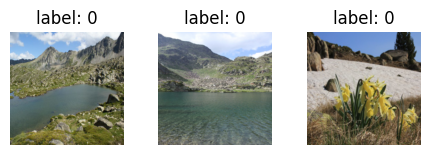

In [206]:
def displayimage(img):
  img  = img.numpy().transpose((1,2,0))
  img = img *[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
  img.clip(0,1)
  plt.imshow(img)
  plt.axis('off')

fig = plt.figure(figsize=(15,5))
for i in range(3):
  ax = plt.subplot(3, 8, i+1)
  img_ = train_set[i][0]
  displayimage(img_)
  ax.set_title(f'label: {train_set[i][1]}')
plt.show()

#### Binary Classification

In [245]:
''' Binary Classification '''
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_ = nn.Sequential(
  nn.Linear(3*224*224, 256),
  nn.ReLU(),
  nn.Linear(256, 128),
  nn.ReLU(),
  nn.Linear(128, 32),
  nn.ReLU(),
  nn.Linear(32, 1),
  nn.Dropout(p=.25),
  nn.Sigmoid()).to(device)

model_2 = nn.Sequential(
  nn.Flatten(),
  nn.Linear(3*224*224, 512),
  nn.ReLU(),
  nn.Dropout(p=.5),
  nn.Linear(512, 256),
  nn.ReLU(),
  nn.Dropout(p=.5),
  nn.Linear(256, 1),
  nn.Sigmoid()).to(device)

lr = 0.001
optimizer=torch.optim.Adam(model_.parameters(), lr)
loss_fn = nn.BCELoss()

In [ ]:
def train_epoch():
  training_loss = 0
  for n, (images, labels) in enumerate(dataloader_train):
    images = images.reshape(-1, 3*224*224)
    images = images.to(device)
    labels = torch.FloatTensor([item_ if item_==0 else 1 for item_ in labels])
    labels = labels.reshape(-1, 1).to(device)
    predictions = model_(images)
    loss = loss_fn(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_loss += loss
  training_loss /= n
  print(f'at epoch {i}, loss is {training_loss}')
  return training_loss

In [ ]:
''' train the binary classifier '''
for i in range(100):
  training_loss = 0
  for n, (images, labels) in enumerate(dataloader_train):
    images = images.reshape(-1, 3*224*224)
    images = images.to(device)
    labels = torch.FloatTensor([item_ if item_==0 else 1 for item_ in labels])
    labels = labels.reshape(-1, 1).to(device)
    predictions = model_(images)
    loss = loss_fn(predictions, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    training_loss += loss
  training_loss /= n
print(f'at epoch {i}, loss is {training_loss}')

In [ ]:
''' accuracy of the classifier '''
results = []
for images, labels in dataloader_test:
  images = images.reshape(-1, 3*224*224).to(device)
  labels = torch.FloatTensor([x if x ==0 else 1 for x in labels])
  labels = (labels).reshape(-1,1).to(device)
  predictions = model_(images)
  predictions_ = torch.where(predictions > .5, 1, 0)
  correct = (predictions_ == labels)
  results.append(correct.detach().cpu().numpy().mean())
accuracy = np.array(results).mean()
accuracy